![](img/330-banner.png)

# Lecture 13: Feature engineering and feature selection 

UBC 2023-24

Instructor: Varada Kolhatkar and Andrew Roth

## Imports

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

## Learning outcomes 

From this lecture, students are expected to be able to:

- Explain what feature engineering is and the importance of feature engineering in building machine learning models.  
- Carry out preliminary feature engineering on numeric and text data. 
- Explain the general concept of feature selection. 
- Discuss and compare different feature selection methods at a high level. 
- Use `sklearn`'s implementation of model-based selection and recursive feature elimination (`RFE`)

## Feature engineering: Motivation

## ❓❓ Questions for you

### iClicker Exercise 13.1 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select the most accurate option below.**

Suppose you are working on a machine learning project. If you have to prioritize one of the following in your project which of the following would it be? 

- (A) The quality and size of the data 
- (B) Most recent deep neural network model 
- (C) Most recent optimization algorithm

**Discussion question**
- Suppose we want to predict whether a flight will arrive on time or be delayed. We have a dataset with the following information about flights:
    - Departure Time
    - Expected Duration of Flight (in minutes)

Upon analyzing the data, you notice a pattern: flights tend to be delayed more often during the evening rush hours. What feature could be valuable to add for this prediction task?
<br><br><br><br>

### Garbage in, garbage out.

- Model building is interesting. But in your machine learning projects, you'll be spending more than half of your time on data preparation, feature engineering, and transformations.
- The _quality_ of the data is important. Your model is only as good as your data. 

### Activity: How can you measure quality of the data? (~3 mins)

- Write some attributes of good- and bad-quality data in 
[this Google Document](https://docs.google.com/document/d/1Nqpcx4yHuVhyrDFrpxbBnduoJC4VFnvVybqzIA1aUmM/edit#heading=h.z9l5ophupovf).

### What is feature engineering?  

- Better features: more flexibility, higher score, we can get by with simple and more interpretable models. 
- If your features, i.e., representation is bad, whatever fancier model you build is not going to help.

<blockquote>
<b>Feature engineering</b> is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.<br> 
- Jason Brownlee    
</blockquote>    



### Some quotes on feature engineering 

A quote by Pedro Domingos [A Few Useful Things to Know About Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

<blockquote>
... At the end of the day, some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used. 
</blockquote>


A quote by Andrew Ng, [Machine Learning and AI via Brain simulations](https://ai.stanford.edu/~ang/slides/DeepLearning-Mar2013.pptx)

<blockquote>
Coming up with features is difficult, time-consuming, requires expert knowledge. "Applied machine learning" is basically feature engineering.
</blockquote>

### Better features usually help more than a better model.
- Good features would ideally:
    - capture most important aspects of the problem
    - allow learning with few examples 
    - generalize to new scenarios.

- There is a trade-off between simple and expressive features:
    - With simple features overfitting risk is low, but scores might be low.
    - With complicated features scores can be high, but so is overfitting risk.

### The best features may be dependent on the model you use.

- Examples:
    - For counting-based methods like decision trees separate relevant groups of variable values
        - Discretization makes sense 
    - For distance-based methods like KNN, we want different class labels to be "far".
        - Standardization 
    - For regression-based methods like linear regression, we want targets to have a linear dependency on features.

#### Domain-specific transformations

In some domains there are natural transformations to do:
- Spectrograms (sound data)
- Wavelets (image data)
- Convolutions 

![](img/spectogram.png)

<!-- <img src="img/spectogram.png" width="800" height="800"> -->

[Source](https://en.wikipedia.org/wiki/Spectrogram)

In this lecture, I'll show you an example of feature engineering on text data. 

<br><br><br><br>

### Feature interactions and feature crosses

- A **feature cross** is a synthetic feature formed by multiplying or crossing two or more features. 
- Example: 
Is the following dataset (XOR function) linearly separable?  

| $$x_1$$ | $$x_2$$ | target|
|---------|---------|---------|
| 1 | 1  | 0|
| -1 | 1  | 1|
| 1 | -1  | 1|
| -1 | -1  | 0|    


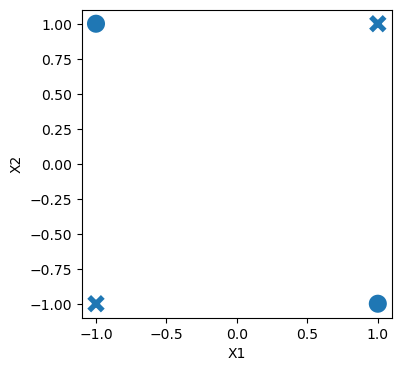

In [9]:
import seaborn as sb
X = np.array([
    [-1, -1],
    [1, -1],
    [-1, 1],
    [1, 1]
])
y = np.array([1, 0, 0, 1])
df = pd.DataFrame(np.column_stack([X, y]), columns=["X1", "X2", "target"])
plt.figure(figsize=(4, 4))
sb.scatterplot(data=df, x="X1", y="X2", style="target", s=200, legend=False);

- For XOR like problems, if we create a feature cross $x1x2$, the data becomes linearly separable. 

| $$x_1$$ | $$x_2$$ | $$x_1x_2$$ | target|
|---------|---------|---------|---------|
| 1 | 1  | 1 | 0|
| -1 | 1  | -1 | 1|
| 1 | -1  | -1 | 1|
| -1 | -1  | 1 | 0|    

In [11]:
df["X1X2"] = df["X1"] * df["X2"]
df

,X1,X2,target,X1X2
0,-1,-1,1,1
1,1,-1,0,-1
2,-1,1,0,-1
3,1,1,1,1


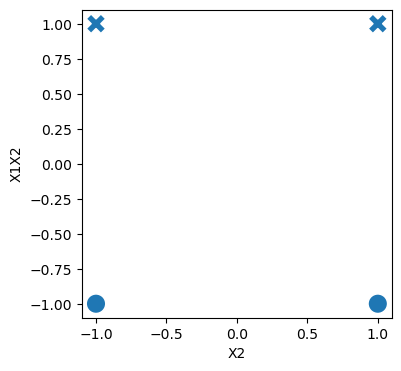

In [13]:
plt.figure(figsize=(4, 4))
sb.scatterplot(data=df, x="X2", y="X1X2", style="target", s=200, legend=False);

Let's look at an example with more data points. 

In [24]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X_xor = rng.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
# Interaction term
Z = X_xor[:, 0] * X_xor[:, 1]

In [25]:
df = pd.DataFrame({'X': X_xor[:, 0], 'Y': X_xor[:, 1], 'Z': Z, 'Class': y_xor})
df.head()

,X,Y,Z,Class
0,1.764052,0.400157,0.705898,False
1,0.978738,2.240893,2.193247,False
2,1.867558,-0.977278,-1.825123,True
3,0.950088,-0.151357,-0.143803,True
4,-0.103219,0.410599,-0.042382,True


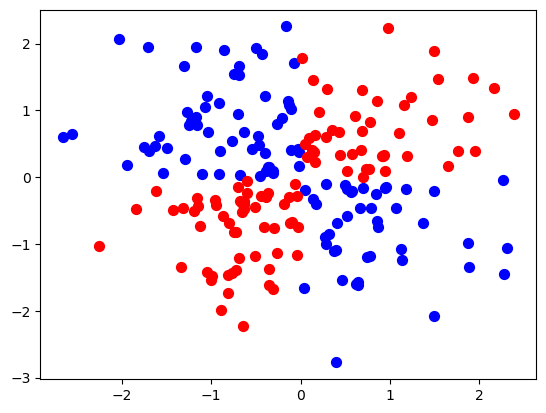

In [26]:
plt.scatter(df[df['Class'] == True]['X'], df[df['Class'] == True]['Y'], c='blue', label='Class 0', s=50)
plt.scatter(df[df['Class'] == False]['X'], df[df['Class'] == False]['Y'], c='red', label='Class 0', s=50);

In [27]:
# Create an interactive 3D scatter plot using plotly
import plotly.express as px
fig = px.scatter_3d(df, x='X', y='Y', z='Z', color='Class', color_continuous_scale=['blue', 'red'])
fig.show();

In [28]:
LogisticRegression().fit(X_xor, y_xor).score(X_xor, y_xor)

0.535

In [29]:
from sklearn.preprocessing import PolynomialFeatures
pipe_xor = make_pipeline(
    PolynomialFeatures(interaction_only=True, include_bias=False), LogisticRegression()
)
pipe_xor.fit(X_xor, y_xor)
pipe_xor.score(X_xor, y_xor)

0.995

In [30]:
feature_names = (
    pipe_xor.named_steps["polynomialfeatures"].get_feature_names_out().tolist()
)

In [31]:
transformed = pipe_xor.named_steps["polynomialfeatures"].transform(X_xor)

In [32]:
pd.DataFrame(
    pipe_xor.named_steps["logisticregression"].coef_.transpose(),
    index=feature_names,
    columns=["Feature coefficient"],
)

,Feature coefficient
x0,-0.028452
x1,0.130408
x0 x1,-5.085959


The interaction feature has the biggest coefficient! 

### Feature crosses for one-hot encoded features
- You can think of feature crosses of one-hot-features as logical conjunctions
- Suppose you want to predict whether you will find parking or not based on two features: 
    - area (possible categories: UBC campus and Rogers Arena)
    - time of the day (possible categories: 9am and 7pm)
- A feature cross in this case would create four new features: 
    - UBC campus and 9am
    - UBC campus and 7pm
    - Rogers Arena and 9am
    - Rogers Arena and 7pm. 
- The features UBC campus and 9am on their own are not that informative but the newly created feature UBC campus and 9am or Rogers Arena and 7pm would be quite informative.

- Coming up with the right combination of features requires some domain knowledge or careful examination of the data. 
- There is no easy way to support feature crosses in sklearn. 

<br><br>

### Demo of feature engineering with numeric features

- Remember the [California housing dataset](https://www.kaggle.com/datasets/camnugent/california-housing-prices) we used earlier in the course? 
- The prediction task is predicting `median_house_value` for a given property. 

In [33]:
housing_df = pd.read_csv("data/california_housing.csv")
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [34]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Suppose we decide to train `ridge` model on this dataset. 

- What would happen if you train a model without applying any transformation on the categorical features ocean_proximity? 
    - Error!! A linear model requires all features in a numeric form.  
- What would happen if we apply OHE on `ocean_proximity` but we do not scale the features?
    - No syntax error. But the model results are likely to be poor. 
- Do we need to apply any other transformations on this data?     

In this section, we will look into some common ways to do feature engineering for numeric or categorical features.  

In [35]:
train_df, test_df = train_test_split(housing_df, test_size=0.2, random_state=123)

We have total rooms and the number of households in the neighbourhood. How about creating rooms_per_household feature using this information? 

In [36]:
train_df = train_df.assign(
    rooms_per_household=train_df["total_rooms"] / train_df["households"]
)
test_df = test_df.assign(
    rooms_per_household=test_df["total_rooms"] / test_df["households"]
)

In [37]:
train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household
9950,-122.33,38.38,28.0,1020.0,169.0,504.0,164.0,4.5694,287500.0,INLAND,6.219512
3547,-118.60,34.26,18.0,6154.0,1070.0,3010.0,1034.0,5.6392,271500.0,<1H OCEAN,5.951644
4448,-118.21,34.07,47.0,1346.0,383.0,1452.0,371.0,1.7292,191700.0,<1H OCEAN,3.628032
6984,-118.02,33.96,36.0,2071.0,398.0,988.0,404.0,4.6226,219700.0,<1H OCEAN,5.126238
4432,-118.20,34.08,49.0,1320.0,309.0,1405.0,328.0,2.4375,114000.0,<1H OCEAN,4.024390
...,...,...,...,...,...,...,...,...,...,...,...
7763,-118.10,33.91,36.0,726.0,NaN,490.0,130.0,3.6389,167600.0,<1H OCEAN,5.584615
15377,-117.24,33.37,14.0,4687.0,793.0,2436.0,779.0,4.5391,180900.0,<1H OCEAN,6.016688
17730,-121.76,37.33,5.0,4153.0,719.0,2435.0,697.0,5.6306,286200.0,<1H OCEAN,5.958393
15725,-122.44,37.78,44.0,1545.0,334.0,561.0,326.0,3.8750,412500.0,NEAR BAY,4.739264


Let's start simple. Imagine that we only three features: `longitude`, `latitude`, and our newly created `rooms_per_household` feature. 

In [38]:
X_train_housing = train_df[["latitude", "longitude", "rooms_per_household"]]
y_train_housing = train_df["median_house_value"]

In [39]:
from sklearn.compose import make_column_transformer

numeric_feats = ["latitude", "longitude", "rooms_per_household"]

preprocessor1 = make_column_transformer(
    (make_pipeline(SimpleImputer(), StandardScaler()), numeric_feats)
)

In [40]:
lr_1 = make_pipeline(preprocessor1, Ridge())
pd.DataFrame(
    cross_validate(lr_1, X_train_housing, y_train_housing, return_train_score=True)
)

,fit_time,score_time,test_score,train_score
0,0.018136,0.001949,0.280028,0.311769
1,0.005248,0.001424,0.325319,0.300464
2,0.003511,0.001297,0.317277,0.301952
3,0.003899,0.001328,0.316798,0.303004
4,0.003403,0.001284,0.260258,0.314840


- The scores are not great. 
- Let's look at the distribution of the longitude and latitude features. 

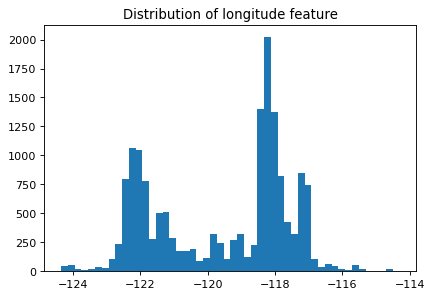

In [41]:
plt.figure(figsize=(6, 4), dpi=80)
plt.hist(train_df["longitude"], bins=50)
plt.title("Distribution of longitude feature");

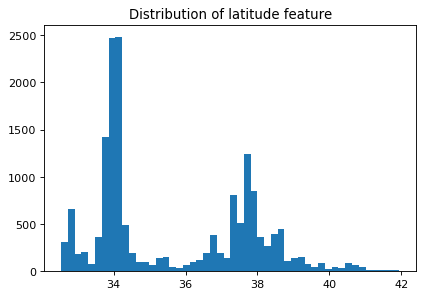

In [42]:
plt.figure(figsize=(6, 4), dpi=80)
plt.hist(train_df["latitude"], bins=50)
plt.title("Distribution of latitude feature");

- Suppose you are planning to build a linear model for housing price prediction. 
- If we think longitude is a good feature for prediction, does it makes sense to use the floating point representation of this feature that's given to us?
- Remember that linear models can capture only linear relationships. 

- How about discretizing latitude and longitude features and putting them into buckets?
- This process of transforming numeric features into categorical features is called bucketing or binning. 
- In `sklearn` you can do this using `KBinsDiscretizer` transformer. 
- Let's examine whether we get better results with binning.

In [43]:
from sklearn.preprocessing import KBinsDiscretizer

discretization_feats = ["latitude", "longitude"]
numeric_feats = ["rooms_per_household"]

preprocessor2 = make_column_transformer(
    (KBinsDiscretizer(n_bins=20, encode="onehot"), discretization_feats),
    (make_pipeline(SimpleImputer(), StandardScaler()), numeric_feats),
)

In [44]:
lr_2 = make_pipeline(preprocessor2, Ridge())
pd.DataFrame(
    cross_validate(lr_2, X_train_housing, y_train_housing, return_train_score=True)
)

,fit_time,score_time,test_score,train_score
0,0.032049,0.003981,0.441445,0.456419
1,0.016939,0.004483,0.469571,0.446216
2,0.016176,0.003384,0.479132,0.446869
3,0.016040,0.003497,0.450822,0.453367
4,0.016045,0.003377,0.388169,0.467628


The results are better with binned features. Let's examine how do these binned features look like. 

In [45]:
lr_2.fit(X_train_housing, y_train_housing)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('kbinsdiscretizer',
                                                  KBinsDiscretizer(n_bins=20),
                                                  ['latitude', 'longitude']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['rooms_per_household'])])),
                ('ridge', Ridge())])

In [46]:
pd.DataFrame(
    preprocessor2.fit_transform(X_train_housing).todense(),
    columns=preprocessor2.get_feature_names_out(),
)

,kbinsdiscretizer__latitude_0.0,kbinsdiscretizer__latitude_1.0,kbinsdiscretizer__latitude_2.0,kbinsdiscretizer__latitude_3.0,kbinsdiscretizer__latitude_4.0,kbinsdiscretizer__latitude_5.0,kbinsdiscretizer__latitude_6.0,kbinsdiscretizer__latitude_7.0,kbinsdiscretizer__latitude_8.0,kbinsdiscretizer__latitude_9.0,...,kbinsdiscretizer__longitude_11.0,kbinsdiscretizer__longitude_12.0,kbinsdiscretizer__longitude_13.0,kbinsdiscretizer__longitude_14.0,kbinsdiscretizer__longitude_15.0,kbinsdiscretizer__longitude_16.0,kbinsdiscretizer__longitude_17.0,kbinsdiscretizer__longitude_18.0,kbinsdiscretizer__longitude_19.0,pipeline__rooms_per_household
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316164
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209903
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.711852
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.117528
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.554621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.064307
16508,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.235706
16509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212581
16510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.271037


How about discretizing all three features? 

In [47]:
from sklearn.preprocessing import KBinsDiscretizer

discretization_feats = ["latitude", "longitude", "rooms_per_household"]

preprocessor3 = make_column_transformer(
    (KBinsDiscretizer(n_bins=20, encode="onehot"), discretization_feats),
)

In [48]:
lr_3 = make_pipeline(preprocessor3, Ridge())
pd.DataFrame(
    cross_validate(lr_3, X_train_housing, y_train_housing, return_train_score=True)
)

,fit_time,score_time,test_score,train_score
0,0.026807,0.003209,0.590618,0.571969
1,0.014674,0.002614,0.575907,0.570473
2,0.014649,0.002734,0.579091,0.573542
3,0.014581,0.002573,0.571500,0.574260
4,0.016785,0.002684,0.541488,0.581687


- The results have improved further!! 
- Let's examine the coefficients

In [49]:
lr_3.fit(X_train_housing, y_train_housing)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('kbinsdiscretizer',
                                                  KBinsDiscretizer(n_bins=20),
                                                  ['latitude', 'longitude',
                                                   'rooms_per_household'])])),
                ('ridge', Ridge())])

In [50]:
feature_names = (
    lr_3.named_steps["columntransformer"]
    .named_transformers_["kbinsdiscretizer"]
    .get_feature_names_out()
)

In [51]:
lr_3.named_steps["ridge"].coef_.shape

(60,)

In [52]:
coefs_df = pd.DataFrame(
    lr_3.named_steps["ridge"].coef_.transpose(),
    index=feature_names,
    columns=["coefficient"],
).sort_values("coefficient", ascending=False)
coefs_df.head

<bound method NDFrame.head of                             coefficient
longitude_1.0             211343.036136
latitude_1.0              205059.296601
latitude_0.0              201862.534342
longitude_0.0             190319.721818
longitude_2.0             160282.191204
longitude_3.0             157234.920305
latitude_2.0              154105.963689
rooms_per_household_19.0  138503.477291
latitude_8.0              135299.516394
longitude_4.0             132292.924485
latitude_7.0              124982.236174
latitude_3.0              118563.786115
longitude_5.0             116145.526596
rooms_per_household_18.0  102044.252042
longitude_6.0              96554.525554
latitude_4.0               92809.389349
latitude_6.0               90982.951669
latitude_9.0               71096.652487
rooms_per_household_17.0   70472.564483
latitude_5.0               69411.023366
longitude_10.0             52398.892961
rooms_per_household_16.0   44311.362553
rooms_per_household_15.0   31454.877046
longitude_

- Does it make sense to take feature crosses in this context?
- What information would they encode? 

<br><br>

### Demo of feature engineering for text data 

We will be using [Covid tweets](https://www.kaggle.com/code/kerneler/starter-covid-19-nlp-text-d3a3baa6-e/data) dataset for this. 

In [53]:
df = pd.read_csv('data/Corona_NLP_test.csv')
df['Sentiment'].value_counts()

Sentiment
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: count, dtype: int64

In [54]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

In [55]:
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1927,1928,46880,"Seattle, WA",13-03-2020,"While I don't like all of Amazon's choices, to...",Positive
1068,1069,46021,NaN,13-03-2020,"Me: shit buckets, its time to do the weekly s...",Negative
803,804,45756,The Outer Limits,12-03-2020,@SecPompeo @realDonaldTrump You mean the plan ...,Neutral
2846,2847,47799,"Flagstaff, AZ",15-03-2020,@lauvagrande People who are sick arent panic ...,Extremely Negative
3768,3769,48721,"Montreal, Canada",16-03-2020,Coronavirus Panic: Toilet Paper Is the People...,Negative
...,...,...,...,...,...,...
1122,1123,46075,NaN,13-03-2020,Photos of our local grocery store shelveswher...,Extremely Positive
1346,1347,46299,Toronto,13-03-2020,Just went to the the grocery store (Highland F...,Positive
3454,3455,48407,"Houston, TX",16-03-2020,Real talk though. Am I the only one spending h...,Neutral
3437,3438,48390,"Washington, DC",16-03-2020,The supermarket business is booming! #COVID2019,Neutral


In [56]:
train_df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [57]:
train_df['Location'].value_counts()

Location
United States                     63
London, England                   37
Los Angeles, CA                   30
New York, NY                      29
Washington, DC                    29
                                  ..
Suburb of Chicago                  1
philippines                        1
Dont ask for freedom, take it.     1
Windsor Heights, IA                1
St James' Park, Newcastle          1
Name: count, Length: 1441, dtype: int64

In [58]:
X_train, y_train = train_df[['OriginalTweet', 'Location']], train_df['Sentiment']
X_test, y_test = test_df[['OriginalTweet', 'Location']], test_df['Sentiment']

In [59]:
y_train.value_counts()

Sentiment
Negative              852
Positive              743
Neutral               501
Extremely Negative    472
Extremely Positive    470
Name: count, dtype: int64

In [60]:
scoring_metrics = 'accuracy'

In [61]:
results = {}

In [62]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

### Dummy classifier

In [63]:
dummy = DummyClassifier()
results["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.001),0.001 (+/- 0.001),0.280 (+/- 0.001),0.280 (+/- 0.000)


### Bag-of-words model 

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
pipe = make_pipeline(CountVectorizer(stop_words='english'), 
                     LogisticRegression(max_iter=1000))
results["logistic regression"] = mean_std_cross_val_scores(
    pipe, X_train['OriginalTweet'], y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.001),0.001 (+/- 0.001),0.280 (+/- 0.001),0.280 (+/- 0.000)
logistic regression,0.479 (+/- 0.032),0.011 (+/- 0.000),0.413 (+/- 0.011),0.999 (+/- 0.000)


### Is it possible to further improve the scores?

- How about adding new features based on our intuitions? Let's extract our own features that might be useful for this prediction task. In other words, let's carry out **feature engineering**. 

- The code below adds some very basic length-related and sentiment features. We will be using a popular library called `nltk` for this exercise. If you have successfully created the course `conda` environment on your machine, you should already have this package in the environment.  

- How do we extract interesting information from text?
- We use **pre-trained models**! 

- A couple of popular libraries which include such pre-trained models. 
- `nltk`
```
conda install -c anaconda nltk 
```        
- spaCy
```
conda install -c conda-forge spacy
```

For emoji support: 
```
pip install spacymoji
```

- You also need to download the language model which contains all the pre-trained models. For that run the following in your course `conda` environment or here.  

In [65]:
import spacy

# !python -m spacy download en_core_web_md

In [66]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/kvarada/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [67]:
nltk.download("vader_lexicon")
nltk.download("punkt")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kvarada/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kvarada/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [68]:
s = "CPSC 330 students are smart, sweet, and funny."
print(sid.polarity_scores(s))

{'neg': 0.0, 'neu': 0.368, 'pos': 0.632, 'compound': 0.8225}


In [69]:
s = "CPSC 330 students are tired because of all the hard work they have been doing."
print(sid.polarity_scores(s))

{'neg': 0.249, 'neu': 0.751, 'pos': 0.0, 'compound': -0.5106}


### [spaCy](https://spacy.io/) 

A useful package for text processing and feature extraction
- Active development: https://github.com/explosion/spaCy
- Interactive lessons by Ines Montani: https://course.spacy.io/en/
- Good documentation, easy to use, and customizable. 

In [70]:
import en_core_web_md  # pre-trained model
import spacy

nlp = en_core_web_md.load()

In [71]:
sample_text = """Dolly Parton is a gift to us all. 
From writing all-time great songs like “Jolene” and “I Will Always Love You”, 
to great performances in films like 9 to 5, to helping fund a COVID-19 vaccine, 
she’s given us so much. Now, Netflix bring us Dolly Parton’s Christmas on the Square, 
an original musical that stars Christine Baranski as a Scrooge-like landowner 
who threatens to evict an entire town on Christmas Eve to make room for a new mall. 
Directed and choreographed by the legendary Debbie Allen and counting Jennifer Lewis 
and Parton herself amongst its cast, Christmas on the Square seems like the perfect movie
to save Christmas 2020. 😻 👍🏿"""

# [Adapted from here.](https://thepopbreak.com/2020/11/22/dolly-partons-christmas-on-the-square-review-not-quite-a-christmas-miracle/)

Spacy extracts all interesting information from text with this call.

In [72]:
doc = nlp(sample_text)

Let's look at part-of-speech tags. 

In [73]:
print([(token, token.pos_) for token in doc][:20])

[(Dolly, 'PROPN'), (Parton, 'PROPN'), (is, 'AUX'), (a, 'DET'), (gift, 'NOUN'), (to, 'ADP'), (us, 'PRON'), (all, 'PRON'), (., 'PUNCT'), (
, 'SPACE'), (From, 'ADP'), (writing, 'VERB'), (all, 'DET'), (-, 'PUNCT'), (time, 'NOUN'), (great, 'ADJ'), (songs, 'NOUN'), (like, 'ADP'), (“, 'PUNCT'), (Jolene, 'PROPN')]


- Often we want to know who did what to whom. 
- **Named entities** give you this information.  
- What are named entities in the text? 

In [74]:
from spacy import displacy

displacy.render(doc, style="ent")

In [75]:
print("Named entities:\n", [(ent.text, ent.label_) for ent in doc.ents])
print("\nORG means: ", spacy.explain("ORG"))
print("\nPERSON means: ", spacy.explain("PERSON"))
print("\nDATE means: ", spacy.explain("DATE"))

Named entities:
 [('Dolly Parton', 'PERSON'), ('Jolene', 'PERSON'), ('9 to 5', 'DATE'), ('Netflix', 'ORG'), ('Dolly Parton', 'PERSON'), ('Christmas', 'DATE'), ('Square', 'FAC'), ('Christine Baranski', 'PERSON'), ('Christmas Eve', 'DATE'), ('Debbie Allen', 'PERSON'), ('Jennifer Lewis', 'PERSON'), ('Parton', 'PERSON'), ('Christmas', 'DATE'), ('Square', 'FAC'), ('Christmas 2020', 'DATE')]

ORG means:  Companies, agencies, institutions, etc.

PERSON means:  People, including fictional

DATE means:  Absolute or relative dates or periods


###  An example from a project 

Goal: Extract and visualize inter-corporate relationships from disclosed annual 10-K reports of public companies. 

[Source for the text below.](https://www.bbc.com/news/business-39875417)

In [76]:
text = (
    "Heavy hitters, including Microsoft and Google, "
    "are competing for customers in cloud services with the likes of IBM and Salesforce."
)

In [77]:
doc = nlp(text)
displacy.render(doc, style="ent")
print("Named entities:\n", [(ent.text, ent.label_) for ent in doc.ents])

Named entities:
 [('Microsoft', 'ORG'), ('Google', 'ORG'), ('IBM', 'ORG'), ('Salesforce', 'PRODUCT')]


If you want emoji identification support install [`spacymoji`](https://pypi.org/project/spacymoji/) in the course environment. 

```
pip install spacymoji
```

After installing `spacymoji`, if it's still complaining about module not found, my guess is that you do not have `pip` installed in your `conda` environment. Go to your course `conda` environment install `pip` and install the `spacymoji` package in the environment using the `pip` you just installed in the current environment. 

```
conda install pip
YOUR_MINICONDA_PATH/miniconda3/envs/cpsc330/bin/pip install spacymoji
```

In [78]:
from spacymoji import Emoji

nlp.add_pipe("emoji", first=True);

Does the text have any emojis? If yes, extract the description. 

In [79]:
doc = nlp(sample_text)
doc._.emoji

[('😻', 138, 'smiling cat with heart-eyes'),
 ('👍🏿', 139, 'thumbs up dark skin tone')]

<br><br><br><br>

## Simple feature engineering for our problem. 

In [80]:
import en_core_web_md
import spacy

nlp = en_core_web_md.load()
from spacymoji import Emoji

nlp.add_pipe("emoji", first=True)

def get_relative_length(text, TWITTER_ALLOWED_CHARS=280.0):
    """
    Returns the relative length of text.

    Parameters:
    ------
    text: (str)
    the input text

    Keyword arguments:
    ------
    TWITTER_ALLOWED_CHARS: (float)
    the denominator for finding relative length

    Returns:
    -------
    relative length of text: (float)

    """
    return len(text) / TWITTER_ALLOWED_CHARS


def get_length_in_words(text):
    """
    Returns the length of the text in words.

    Parameters:
    ------
    text: (str)
    the input text

    Returns:
    -------
    length of tokenized text: (int)

    """
    return len(nltk.word_tokenize(text))


def get_sentiment(text):
    """
    Returns the compound score representing the sentiment: -1 (most extreme negative) and +1 (most extreme positive)
    The compound score is a normalized score calculated by summing the valence scores of each word in the lexicon.

    Parameters:
    ------
    text: (str)
    the input text

    Returns:
    -------
    sentiment of the text: (str)
    """
    scores = sid.polarity_scores(text)
    return scores["compound"]

def get_avg_word_length(text):
    """
    Returns the average word length of the given text.

    Parameters:
    text -- (str)
    """
    words = text.split()
    return sum(len(word) for word in words) / len(words)


def has_emoji(text):
    """
    Returns the average word length of the given text.

    Parameters:
    text -- (str)
    """
    doc = nlp(text)
    return 1 if doc._.has_emoji else 0

In [81]:
train_df = train_df.assign(n_words=train_df["OriginalTweet"].apply(get_length_in_words))
train_df = train_df.assign(vader_sentiment=train_df["OriginalTweet"].apply(get_sentiment))
train_df = train_df.assign(rel_char_len=train_df["OriginalTweet"].apply(get_relative_length))

test_df = test_df.assign(n_words=test_df["OriginalTweet"].apply(get_length_in_words))
test_df = test_df.assign(vader_sentiment=test_df["OriginalTweet"].apply(get_sentiment))
test_df = test_df.assign(rel_char_len=test_df["OriginalTweet"].apply(get_relative_length))


train_df = train_df.assign(
    average_word_length=train_df["OriginalTweet"].apply(get_avg_word_length)
)
test_df = test_df.assign(average_word_length=test_df["OriginalTweet"].apply(get_avg_word_length))

# whether all letters are uppercase or not (all_caps)
train_df = train_df.assign(
    all_caps=train_df["OriginalTweet"].apply(lambda x: 1 if x.isupper() else 0)
)
test_df = test_df.assign(
    all_caps=test_df["OriginalTweet"].apply(lambda x: 1 if x.isupper() else 0)
)

train_df = train_df.assign(has_emoji=train_df["OriginalTweet"].apply(has_emoji))
test_df = test_df.assign(has_emoji=test_df["OriginalTweet"].apply(has_emoji))

train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,n_words,vader_sentiment,rel_char_len,average_word_length,all_caps,has_emoji
1927,1928,46880,"Seattle, WA",13-03-2020,"While I don't like all of Amazon's choices, to...",Positive,31,-0.1053,0.589286,5.640000,0,0
1068,1069,46021,NaN,13-03-2020,"Me: shit buckets, its time to do the weekly s...",Negative,52,-0.2500,0.932143,4.636364,0,0
803,804,45756,The Outer Limits,12-03-2020,@SecPompeo @realDonaldTrump You mean the plan ...,Neutral,44,0.0000,0.910714,6.741935,0,0
2846,2847,47799,"Flagstaff, AZ",15-03-2020,@lauvagrande People who are sick arent panic ...,Extremely Negative,46,-0.8481,0.907143,5.023810,0,0
3768,3769,48721,"Montreal, Canada",16-03-2020,Coronavirus Panic: Toilet Paper Is the People...,Negative,21,-0.5106,0.500000,9.846154,0,0


In [82]:
train_df.shape

(3038, 12)

In [83]:
(train_df['all_caps'] == 1).sum()

0

In [84]:
X_train = train_df.drop(columns=['Sentiment'])

In [85]:
numeric_features = ['vader_sentiment', 
                    'rel_char_len', 
                    'average_word_length']
passthrough_features = ['all_caps', 'has_emoji'] 
text_feature = 'OriginalTweet'
drop_features = ['UserName', 'ScreenName', 'Location', 'TweetAt']

In [86]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    ("passthrough", passthrough_features), 
    (CountVectorizer(stop_words='english'), text_feature),
    ("drop", drop_features)
)

In [87]:
pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
results["LR (more feats)"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.001),0.001 (+/- 0.001),0.280 (+/- 0.001),0.280 (+/- 0.000)
logistic regression,0.479 (+/- 0.032),0.011 (+/- 0.000),0.413 (+/- 0.011),0.999 (+/- 0.000)
LR (more feats),0.474 (+/- 0.050),0.013 (+/- 0.000),0.689 (+/- 0.007),0.998 (+/- 0.001)


In [88]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['vader_sentiment',
                                                   'rel_char_len',
                                                   'average_word_length']),
                                                 ('passthrough', 'passthrough',
                                                  ['all_caps', 'has_emoji']),
                                                 ('countvectorizer',
                                                  CountVectorizer(stop_words='english'),
                                                  'OriginalTweet'),
                                                 ('drop', 'drop',
                                                  ['UserName', 'ScreenName',
                                                   'Location', 'TweetAt'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [89]:
cv_feats = pipe.named_steps['columntransformer'].named_transformers_['countvectorizer'].get_feature_names_out().tolist()

In [90]:
feat_names = numeric_features + passthrough_features + cv_feats

In [91]:
coefs = pipe.named_steps['logisticregression'].coef_[0]

In [92]:
df = pd.DataFrame(
    data={
        "features": feat_names,
        "coefficients": coefs,
    }
)
df.sort_values('coefficients')

,features,coefficients
0,vader_sentiment,-6.141919
11331,won,-1.369740
2551,coronapocalypse,-0.809931
2214,closed,-0.744717
8661,retail,-0.723808
...,...,...
9862,stupid,1.157669
3299,don,1.159067
4879,hell,1.311957
3129,die,1.366538


We get some improvements with our engineered features! 

Check [Appendix-A](Appendix-A.ipynb) for commonly used features in text classification. 

### Interim summary 

- Feature engineering is finding the useful representation of the data that can help us effectively solve our problem. 
- In the context of text data, if we want to go beyond bag-of-words and incorporate human knowledge in models, we carry out feature engineering. 
- Some common features include:
    - ngram features
    - part-of-speech features
    - named entity features
    - emoticons in text
- These are usually extracted from pre-trained models using libraries such as `spaCy`.  
- Now a lot of this has moved to deep learning.
- But many industries still rely on manual feature engineering. 

<br><br>

- The best features are application-dependent.
- It's hard to give general advice. But here are some guidelines. 
    - Ask the domain experts.
    - Go through academic papers in the discipline. 
    - Often have idea of right discretization/standardization/transformation.
    - If no domain expert, cross-validation will help.
- If you have lots of data, use deep learning methods. 

<blockquote>
    The algorithms we used are very standard for Kagglers ... We spent most of our efforts in feature engineering... <br>
- Xavier Conort, on winning the Flight Quest challenge on Kaggle    
</blockquote>    

## Break (5 min)

![](img/eva-coffee.png)

<br><br><br><br>

## Feature selection: Introduction and motivation 


- With so many ways to add new features, we can increase dimensionality of the data. 
- More features means more complex models, which means increasing the chance of overfitting. 


### What is feature selection?

- Find the features	(columns) $X$ that are important for predicting	$y$, and remove the features that aren't. 

- Given $X = \begin{bmatrix}x_1 & x_2 & \dots & x_n\\  \\  \\  \end{bmatrix}$ and $y = \begin{bmatrix}\\  \\  \\  \end{bmatrix}$, find the columns $1 \leq j \leq n$ in $X$ that are important for predicting $y$.


### Why feature selection? 

- Interpretability: Models are more interpretable with fewer features. If you get the same performance with 10 features instead of 500 features, why not use the model with smaller number of features?     
- Computation: Models fit/predict faster with fewer columns.
- Data collection: What type of new data should I collect? It may be cheaper to collect fewer columns.
- Fundamental tradeoff: Can I reduce overfitting by removing useless features?

Feature selection can often result in better performing (less overfit), easier to understand, and faster model. 


### How do we carry out feature selection? 

- There are a number of ways. 
- You could use domain knowledge to discard features. 
- We are briefly going to look at two automatic feature selection methods from `sklearn`: 
    - Model-based selection 
    - Recursive feature elimination
    - Forward/backward selection 
- Very related to looking at feature importances.

In [93]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0, test_size=0.5
)

In [94]:
X_train.shape

(284, 30)

In [95]:
pipe_lr_all_feats = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe_lr_all_feats.fit(X_train, y_train)
pd.DataFrame(
    cross_validate(pipe_lr_all_feats, X_train, y_train, return_train_score=True)
).mean()

fit_time       0.003118
score_time     0.000510
test_score     0.968233
train_score    0.987681
dtype: float64

### Model-based selection

- Use a supervised machine learning model to judge the importance of each feature.
- Keep only the most important once. 
- Supervised machine learning model used for feature selection can be different that the one used as the final estimator. 
- Use a model which has some way to calculate feature importances.

- To use model-based selection, we use `SelectFromModel` transformer.
- It selects features which have the feature importances greater than the provided threshold.
- Below I'm using `RandomForestClassifier` for feature selection with threahold "median" of feature importances. 
- Approximately how many features will be selected? 

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

select_rf = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42), 
    threshold="median"
)

Can we use KNN to select features?

In [79]:
select_knn = SelectFromModel(
    KNeighborsClassifier(), 
    threshold="median"
)

pipe_lr_model_based = make_pipeline(
    StandardScaler(), select_knn, LogisticRegression(max_iter=1000)
)

#pd.DataFrame(
#    cross_validate(pipe_lr_model_based, X_train, y_train, return_train_score=True)#
#).mean()

**No** KNN won't work since it does not report feature importances.

What about SVC?

In [97]:
select_svc = SelectFromModel(
    SVC(), threshold="median"
)

# pipe_lr_model_based = make_pipeline(
#     StandardScaler(), select_svc, LogisticRegression(max_iter=1000)
# )

# pd.DataFrame(
#    cross_validate(pipe_lr_model_based, X_train, y_train, return_train_score=True)
# ).mean()

Only with a linear kernel but not with RBF kernel

We can put the feature selection transformer in a pipeline. 

In [98]:
pipe_lr_model_based = make_pipeline(
    StandardScaler(), select_rf, LogisticRegression(max_iter=1000)
)

pd.DataFrame(
    cross_validate(pipe_lr_model_based, X_train, y_train, return_train_score=True)
).mean()

fit_time       0.089411
score_time     0.004722
test_score     0.950564
train_score    0.974480
dtype: float64

In [99]:
pipe_lr_model_based = make_pipeline(
    StandardScaler(), select_rf, LogisticRegression(max_iter=1000)
)

pd.DataFrame(
    cross_validate(pipe_lr_model_based, X_train, y_train, return_train_score=True)
).mean()

fit_time       0.088459
score_time     0.004785
test_score     0.950564
train_score    0.974480
dtype: float64

In [100]:
pipe_lr_model_based.fit(X_train, y_train)
pipe_lr_model_based.named_steps["selectfrommodel"].transform(X_train).shape

(284, 15)

Similar results with only 15 features instead of 30 features. 

### Recursive feature elimination (RFE)

- Build a series of models
- At each iteration, discard the least important feature according to the model. 
- Computationally expensive
- Basic idea
    - fit model
    - find least important feature
    - remove
    - iterate.

### RFE algorithm 

1. Decide $k$, the number of features to select. 
2. Assign importances to features, e.g. by fitting a model and looking at `coef_` or `feature_importances_`.
3. Remove the least important feature.
4. Repeat steps 2-3 until only $k$ features are remaining.

Note that this is **not** the same as just removing all the less important features in one shot!

In [101]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [102]:
from sklearn.feature_selection import RFE

# create ranking of features
rfe = RFE(LogisticRegression(), n_features_to_select=5)
rfe.fit(X_train_scaled, y_train)
rfe.ranking_

array([16, 12, 19, 13, 23, 20, 10,  1,  9, 22,  2, 25,  5,  7, 15,  4, 26,
       18, 21,  8,  1,  1,  1,  6, 14, 24,  3,  1, 17, 11])

In [103]:
print(rfe.support_)

[False False False False False False False  True False False False False
 False False False False False False False False  True  True  True False
 False False False  True False False]


In [104]:
print("selected features: ", cancer.feature_names[rfe.support_])

selected features:  ['mean concave points' 'worst radius' 'worst texture' 'worst perimeter'
 'worst concave points']


- How do we know what value to pass to `n_features_to_select`?

- Use `RFECV` which uses cross-validation to select number of features. 

In [105]:
from sklearn.feature_selection import RFECV

rfe_cv = RFECV(LogisticRegression(max_iter=2000), cv=10)
rfe_cv.fit(X_train_scaled, y_train)
print(rfe_cv.support_)
print(cancer.feature_names[rfe_cv.support_])

[False  True False  True False False  True  True  True False  True False
  True  True False  True False False False  True  True  True  True  True
 False False  True  True False  True]
['mean texture' 'mean area' 'mean concavity' 'mean concave points'
 'mean symmetry' 'radius error' 'perimeter error' 'area error'
 'compactness error' 'fractal dimension error' 'worst radius'
 'worst texture' 'worst perimeter' 'worst area' 'worst concavity'
 'worst concave points' 'worst fractal dimension']


In [106]:
rfe_pipe = make_pipeline(
    StandardScaler(),
    RFECV(LogisticRegression(max_iter=2000), cv=10),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

pd.DataFrame(cross_validate(rfe_pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       0.636661
score_time     0.003365
test_score     0.943609
train_score    1.000000
dtype: float64

- Slow because there is cross validation within cross validation 
- Not a big improvement in scores compared to all features on this toy case

<br><br>

### (Optional) Search and score

- Define a **scoring function** $f(S)$ that measures the quality of the set of features $S$. 
- Now **search** for the set of features $S$ with the best score.

### General idea of search and score methods 

- Example: Suppose you have three features: $A, B, C$
    - Compute **score** for $S = \{\}$
    - Compute **score** for $S = \{A\}$
    - Compute **score** for $S= \{B\}$
    - Compute **score** for $S = \{C\}$
    - Compute **score** for $S = \{A,B\}$    
    - Compute **score** for $S = \{A,C\}$
    - Compute **score** for $S = \{B,C\}$
    - Compute **score** for $S = \{A,B,C\}$    
- Return $S$ with the best score.  
- How many distinct combinations we have to try out? 

### (Optional) Forward or backward selection 

- Also called wrapper methods
- Shrink or grow feature set by removing or adding one feature at a time 
- Makes the decision based on whether adding/removing the feature improves the CV score or not

![](img/forward_selection.png)

<!-- <img src='img/forward_selection.png' width="1000" height="1000" /> -->

In [ ]:
# from sklearn.feature_selection import SequentialFeatureSelector

# pipe_forward = make_pipeline(
#     StandardScaler(),
#     SequentialFeatureSelector(LogisticRegression(max_iter=1000), 
#                               direction="forward", 
#                               n_features_to_select='auto', 
#                               tol=None),
#     RandomForestClassifier(n_estimators=100, random_state=42),
# )
# pd.DataFrame(
#     cross_validate(pipe_forward, X_train, y_train, return_train_score=True)
# ).mean()

In [ ]:
# pipe_forward = make_pipeline(
#     StandardScaler(),
#     SequentialFeatureSelector(
#         LogisticRegression(max_iter=1000), 
#                            direction="backward", 
#                            n_features_to_select=15),
#     RandomForestClassifier(n_estimators=100, random_state=42),
# )
# pd.DataFrame(
#     cross_validate(pipe_forward, X_train, y_train, return_train_score=True)
# ).mean()

### Other ways to search 

- Stochastic local search
    - Inject randomness so that we can explore new parts of the search space
    - Simulated annealing
    - Genetic algorithms

### Warnings about feature selection 

- A feature's relevance is only defined in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- If features can be predicted from other features, you cannot know which one to pick. 
- Relevance for features does not have a causal relationship. 
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$ for the data you have.

### (iClicker) Exercise 13.1 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- (A) Simple association-based feature selection approaches do not take into account the interaction between features.
- (B) You can carry out feature selection using linear models by pruning the features which have very small weights (i.e., coefficients less than a threshold).
- (C) Forward search is guaranteed to find the best feature set.  
- (D) The order of features removed given by `rfe.ranking_` is the same as the order of original feature importances given by the model.  

<br><br><br><br>

### (Optional) Problems with feature selection 

- The term 'relevance' is not clearly defined.
- What all things can go wrong with feature selection?
- Attribution: From CPSC 340. 

#### Example: Is "Relevance" clearly defined?

- Consider a supervised classification task of predicting whether someone has particular genetic variation (SNP)

<img src='img/sex_mom_dad.png' width="600" height="600" />

- True model: You almost have the same value as your biological mom.

#### Is "Relevance" clearly defined?

- True model: You almost have the same value for SNP as your biological mom.
    - (SNP = biological mom) with very high probability 
    - (SNP != biological mom) with very low probability 
    

<img src='img/SNP.png' width="400" height="400"/>


#### Is "Relevance" clearly defined?

- What if "mom" feature is repeated?
- Should we pick both? Should we pick one of them because it predicts the other? 
- Dependence, collinearity for linear models
    - If a feature can be predicted from the other, don't know which one to pick. 

<img src='img/sex_mom_mom2_dad.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- What if we add (maternal) "grandma" feature?
- Is it relevant? 
    - We can predict SNP accurately using this feature
- Conditional independence
    - But grandma is irrelevant given biological mom feature
    - Relevant features may become irrelevant given other features

<img src='img/sex_mom_dad_grandma.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- What if we do not know biological mom feature and we just have grandma feature
- It becomes relevant now. 
    - Without mom feature this is the best we can do. 
- General problem ("taco Tuesday" problem)
    - Features can become relevant due to missing information 


<img src='img/sex_dad_grandma.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- Are there any relevant features now?
- They may have some common maternal ancestor.   
- What if mom likes dad because they share SNP? 
- General problem (Confounding)
    - Hidden features can make irrelevant features relevant.

<img src='img/sex_dad.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- Now what if we have "sibling" feature? 
- The feature is relevant in predicting SNP but not the cause of SNP. 
- General problem (non causality)
    - the relevant feature may not be causal 

<img src='img/sex_dad_sibling.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- What if you are given "baby" feature?
- Now the sex feature becomes relevant. 
    - "baby" feature is relevant when sex == F
    
- General problem (context specific relevance)
    - adding a feature can make an irrelevant feature relevant

<img src='img/sex_dad_baby.png' width="600" height="600"/>


#### Warnings about feature selection 

- A feature is only relevant in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- Confounding factors can make irrelevant features the most relevant.
- If features can be predicted from other other features, you cannot know which one to pick. 
- Relevance for features does not have a causal relationship. 

- Is feature selection completely hopeless?
    - It is messy but we still need to do it. So we try to do our best! 

#### General advice on finding relevant features

- Try forward selection. 
- Try other feature selection methods (e.g., `RFE`, simulated annealing, genetic algorithms)
- Talk to domain experts; they probably have an idea why certain features are relevant.
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$.

#### Relevant resources 
- [Genome-wide association study](https://en.wikipedia.org/wiki/Genome-wide_association_study)
- [sklearn feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)
- [PyData: A Practical Guide to Dimensionality Reduction Techniques](https://www.youtube.com/watch?v=ioXKxulmwVQ)